# pyfolio library이용해서 backtest 해보기


* 일별로 종가를 1주씩 샀을때를 예시로 들었다

* Library 
    * FinanceDataReader
    * pyfolio


In [1]:
import warnings
warnings.filterwarnings('ignore')
import FinanceDataReader as fdr
import pyfolio as pf
import pandas as pd
import numpy as np
import datetime
import backtrader as bt

## 'US500' (2007.1.1 ~ current)

Start date,2006-01-04
End date,2020-06-08
Total months,172
,Backtest
Annual return,6.68%
Cumulative returns,153.827%
Annual volatility,20.315%
Sharpe ratio,0.42
Calmar ratio,0.12
Stability,0.77
Max drawdown,-56.775%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,56.78,2007-10-09,2009-03-09,2013-03-28,1428
1,33.92,2020-02-19,2020-03-23,NaT,NaN
2,19.78,2018-09-20,2018-12-24,2019-04-23,154
3,14.16,2015-05-21,2016-02-11,2016-07-11,298
4,10.16,2018-01-26,2018-02-08,2018-08-24,151


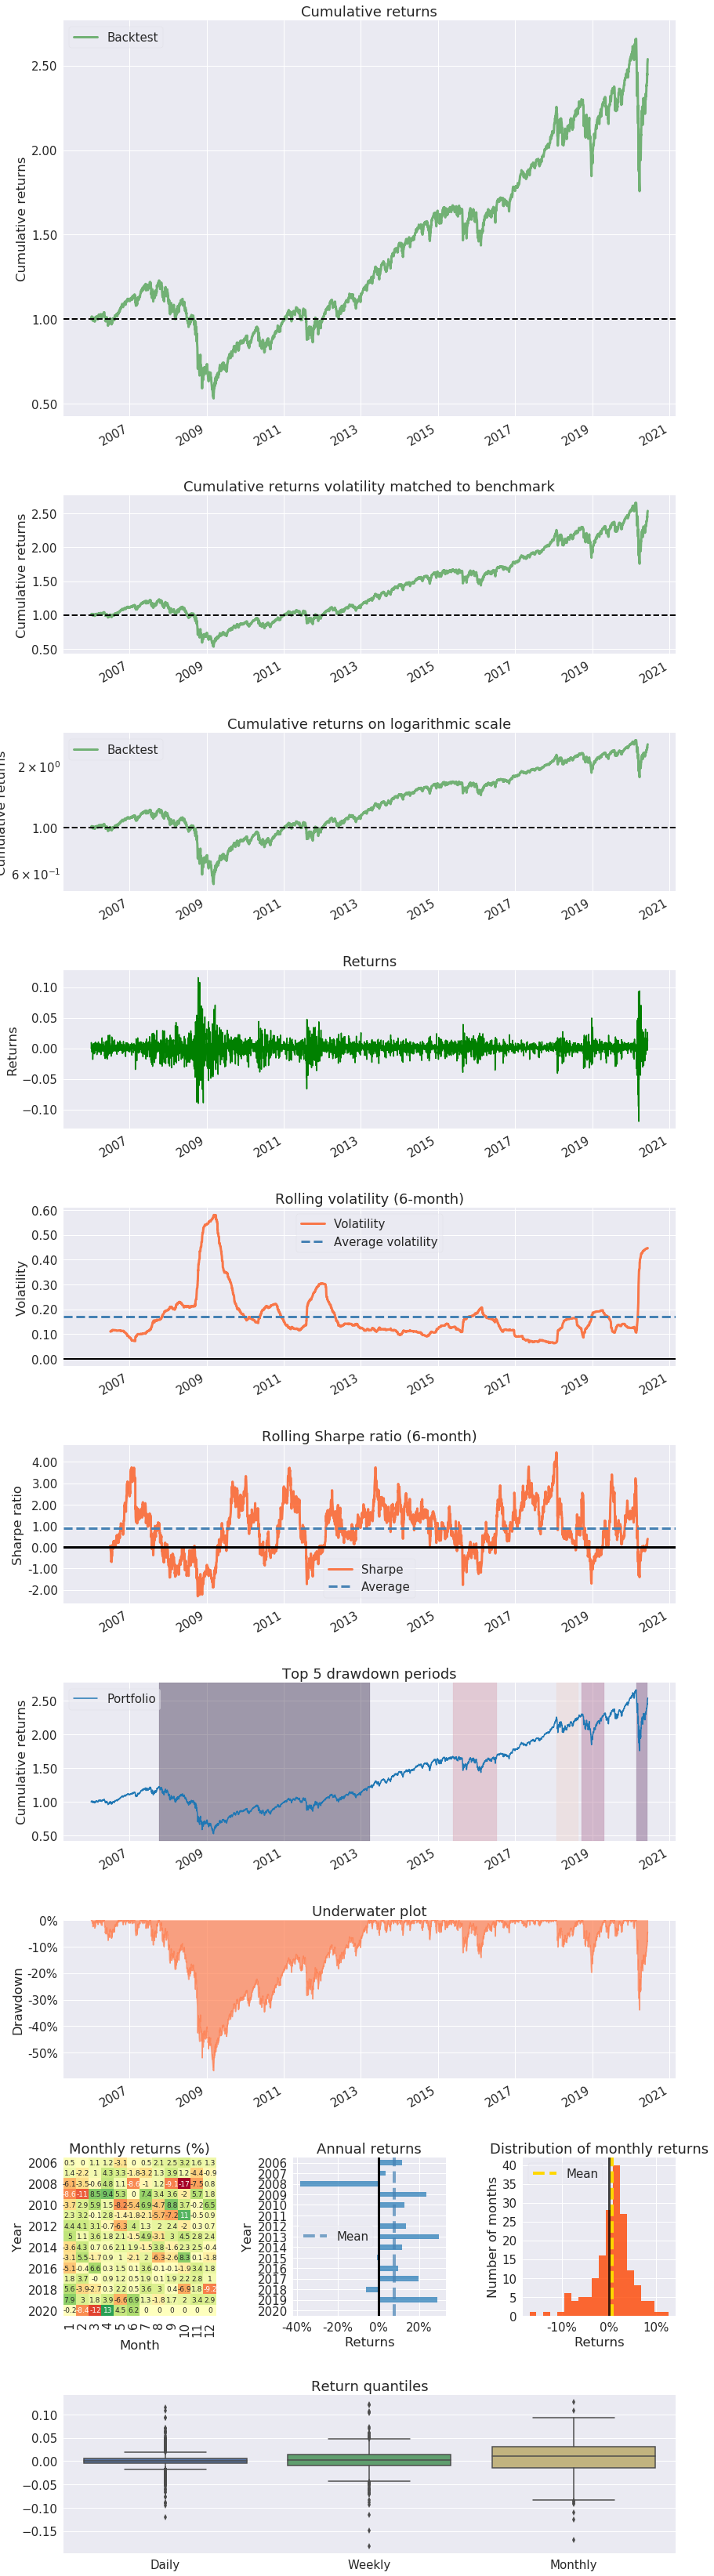

In [2]:
df = fdr.DataReader('US500')
return_series = df['Close'].pct_change().fillna(0)
pf.create_returns_tear_sheet(return_series)

## KAKAO (2017.8.2 ~ 2018.12.30)

Start date,2017-08-02
End date,2018-12-28
Total months,16
,Backtest
Annual return,-7.482%
Cumulative returns,-10.044%
Annual volatility,38.067%
Sharpe ratio,-0.02
Calmar ratio,-0.16
Stability,0.46
Max drawdown,-45.59%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,45.59,2017-11-21,2018-10-29,NaT,NaN
1,12.23,2017-10-12,2017-10-26,2017-11-20,28
2,5.24,2017-08-03,2017-08-09,2017-08-16,10
3,2.85,2017-08-31,2017-09-04,2017-09-05,4
4,2.81,2017-09-20,2017-09-22,2017-09-29,8


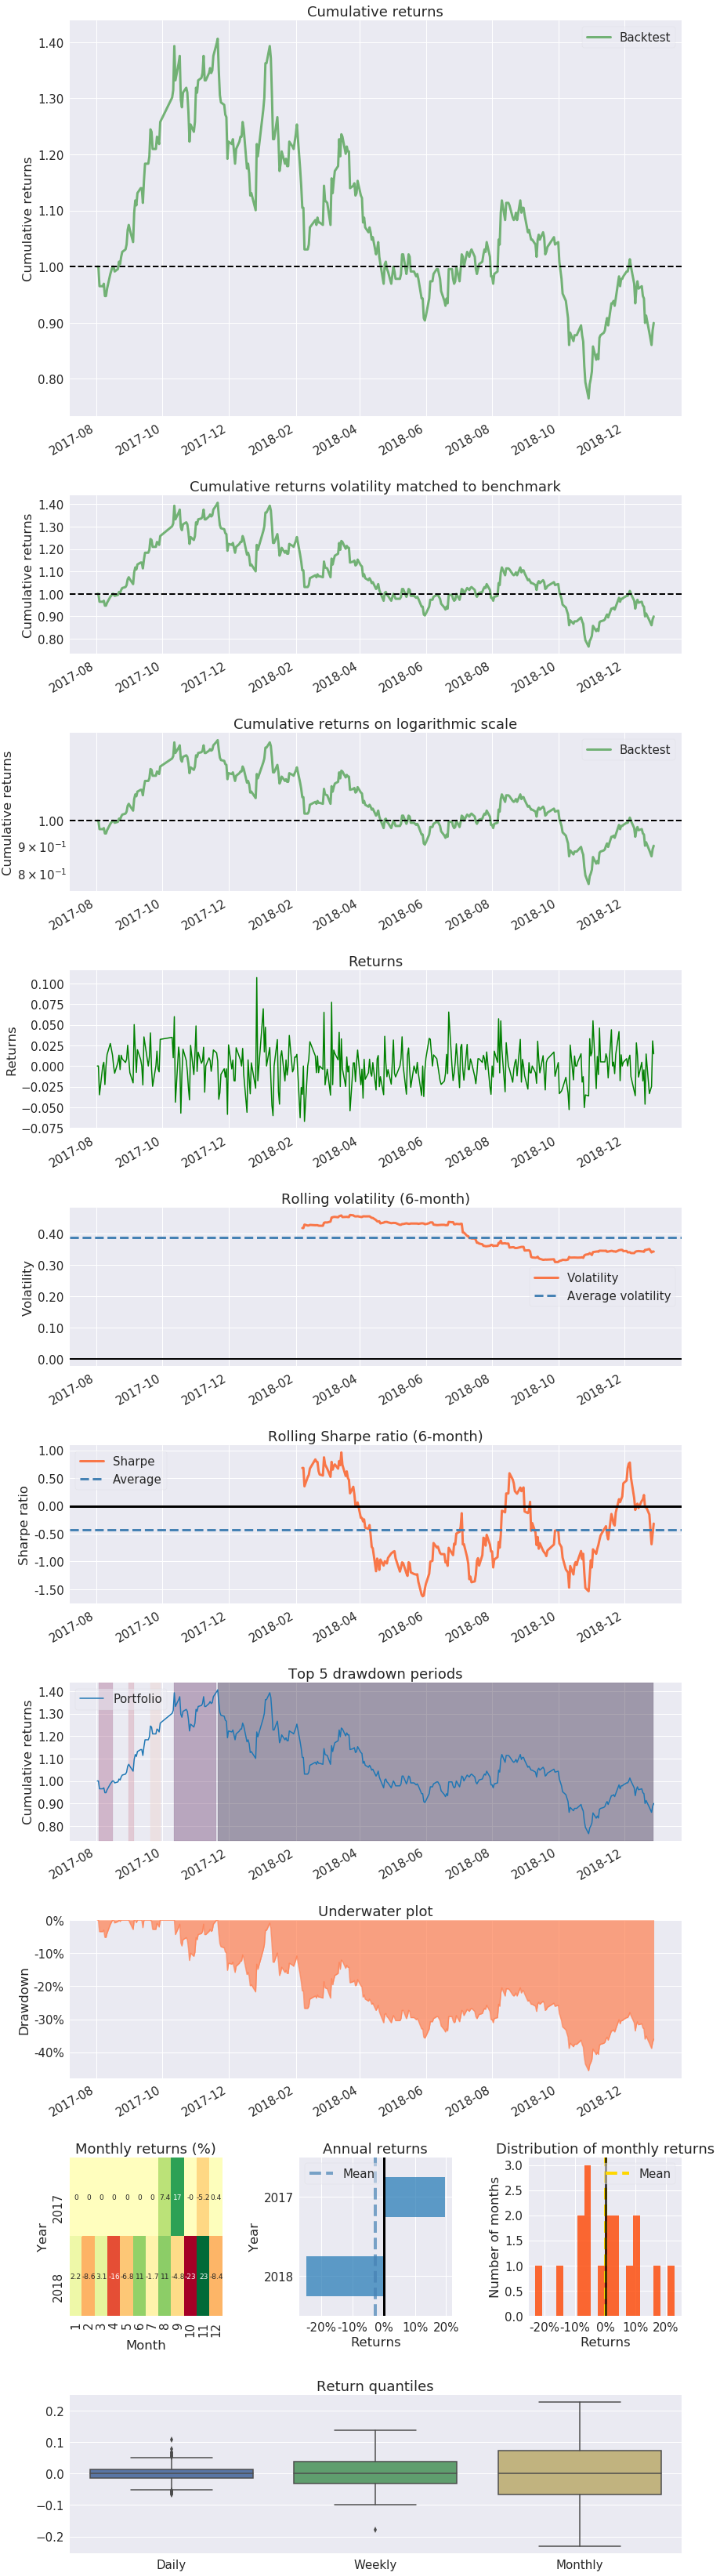

In [3]:
start = datetime.datetime(2017, 8, 2)
end = datetime.datetime(2018, 12, 30)
df = fdr.DataReader('035720',start,end) 
a = df['Close'].pct_change().fillna(0)
pf.create_returns_tear_sheet(a)

# backtrader 이용해서 backtest 해보기

## Momentum 전략

In [4]:
import datetime
import backtrader as bt

In [5]:
# Create a subclass of Strategy to define the indicators and logic
class Momentum(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=20  # period for the slow moving average
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.smaSlow = bt.ind.SimpleMovingAverage(period=self.p.pslow)
        self.smaFast = bt.ind.SimpleMovingAverage(period=self.p.pfast)
        self.order = None

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        # 1. If order is submitted/accepted, do nothing
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 2. If order is buy/sell executed, report price executed
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: {0:8.2f}, Size: {1:8.2f} Cost: {2:8.2f}, Comm: {3:8.2f}'.format(
                    order.executed.price,
                    order.executed.size,
                    order.executed.value,
                    order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log('SELL EXECUTED, {0:8.2f}, Size: {1:8.2f} Cost: {2:8.2f}, Comm{3:8.2f}'.format(
                    order.executed.price,
                    order.executed.size,
                    order.executed.value,
                    order.executed.comm))

            self.bar_executed = len(self)  # when was trade executed
        # 3. If order is canceled/margin/rejected, report order canceled
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def next(self):
        cash = self.broker.get_cash()
        value = self.broker.get_value()
        size = int(cash / self.data.close[0])
        # Order가 Pending인지 확인, 그렇다면 다시 주문할 수 없음
        if self.order:
            return

        if not self.position:  # not in the market
            if self.smaSlow < self.data.close[0]:
                self.order = self.buy(size=size)

        elif self.getposition().size > 0: #in the market
            if self.smaSlow > self.data.close[0]:
                self.order = self.sell(size=self.getposition().size)

## run module

In [6]:
def run(strategy,data):
    cerebro = bt.Cerebro()  # create a "Cerebro" engine instance

    cerebro.broker.setcash(1000000) #초기자금
    cerebro.broker.setcommission(commission=0.00015) # 매매 수수료는 0.015% 설정
    cerebro.adddata(data) #데이터 삽입
    cerebro.addstrategy(strategy) #전략적용
    a = cerebro.broker.getvalue()
    print('Starting Portfolio Value: %.2f' % a)
    cerebro.run() #수행
    b = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f' % b)
    c = ((b-a)/a)*100
    print('Returns : %.2f %%' % c)
    cerebro.plot() #plot

Starting Portfolio Value: 1000000.00
2019-01-30, BUY EXECUTED, Price: 44800.00, Size:    21.00 Cost: 940800.00, Comm:   141.12
2019-03-04, SELL EXECUTED, 46000.00, Size:   -21.00 Cost: 940800.00, Comm  144.90
2019-03-22, Order Canceled/Margin/Rejected
2019-03-25, BUY EXECUTED, Price: 45300.00, Size:    22.00 Cost: 996600.00, Comm:   149.49
2019-04-19, SELL EXECUTED, 45750.00, Size:   -22.00 Cost: 996600.00, Comm  150.97
2019-04-30, BUY EXECUTED, Price: 46000.00, Size:    22.00 Cost: 1012000.00, Comm:   151.80
2019-05-02, SELL EXECUTED, 45500.00, Size:   -22.00 Cost: 1012000.00, Comm  150.15
2019-05-24, BUY EXECUTED, Price: 43800.00, Size:    23.00 Cost: 1007400.00, Comm:   151.11
2019-05-27, SELL EXECUTED, 42500.00, Size:   -23.00 Cost: 1007400.00, Comm  146.62
2019-06-04, BUY EXECUTED, Price: 43400.00, Size:    22.00 Cost: 954800.00, Comm:   143.22
2019-07-09, SELL EXECUTED, 44850.00, Size:   -22.00 Cost: 954800.00, Comm  148.00
2019-07-11, BUY EXECUTED, Price: 46350.00, Size:    22.0

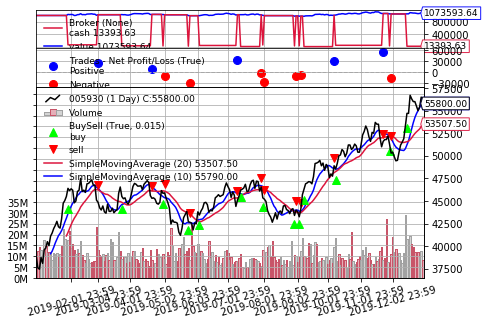

In [7]:
data = bt.feeds.YahooFinanceData(dataname='005930.KS',
                                     fromdate=datetime.datetime(2019, 1, 1),
                                     todate=datetime.datetime(2019, 12, 31))
if __name__ == '__main__':
    run(Momentum,data)

## SmaCross 전략 (미완성)

In [8]:
class SmaCross(bt.Strategy): # bt.Strategy를 상속한 class로 생성해야 함.
    params = dict(
    pfast=5, # period for the fast moving average
    pslow=30 # period for the slow moving average
    )
    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast) # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow) # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2) # crossover signal
    def next(self):
        if not self.position: # not in the market
            if self.datetime.date() == datetime.date(2019, 5, 17): # if fast crosses slow to the upside
                close = self.data.close[0] # 종가 값
                size = int(self.broker.getcash() / close) # 최대 구매 가능 개수
                self.buy(size=size) # 매수 size = 구매 개수 설정
        elif self.datetime.date() == datetime.date(2019, 5, 29): # in the market & cross to the downside
            self.close() # 매도

## 내가 만든 전략1 
* KAKAO 실적발표일에 매수 - 4일 있다가 매도

In [9]:
class Performance(bt.Strategy): # bt.Strategy를 상속한 class로 생성해야 함.

    def __init__(self):
        self.b = 30
        self.c = 3

    def next(self):
        if self.datetime.date() == datetime.date(2019,4,self.b): # if fast crosses slow to the upside
            close = self.data.close[0] # 종가 값
            size = int(self.broker.getcash() / close) # 최대 구매 가능 개수
            self.buy(size=size) # 매수 size = 구매 개수 설정
        elif self.datetime.date() == datetime.date(2019, 5, self.c): # in the market & cross to the downside
            self.close() # 매도
        elif self.datetime.date() == datetime.date(2019, 8, 2): # if fast crosses slow to the upside
                close = self.data.close[0] # 종가 값
                size = int(self.broker.getcash() / close) # 최대 구매 가능 개수
                self.buy(size=size) # 매수 size = 구매 개수 설정
        elif self.datetime.date() == datetime.date(2019, 8, 6): # in the market & cross to the downside
            self.close() # 매도
        elif self.datetime.date() == datetime.date(2019, 11, 1): # if fast crosses slow to the upside
                close = self.data.close[0] # 종가 값
                size = int(self.broker.getcash() / close) # 최대 구매 가능 개수
                self.buy(size=size) # 매수 size = 구매 개수 설정
        elif self.datetime.date() == datetime.date(2019, 11, 5): # in the market & cross to the downside
            self.close() # 매도
        elif self.datetime.date() == datetime.date(2019, 2, 11): # if fast crosses slow to the upside
                close = self.data.close[0] # 종가 값
                size = int(self.broker.getcash() / close) # 최대 구매 가능 개수
                self.buy(size=size) # 매수 size = 구매 개수 설정
        elif self.datetime.date() == datetime.date(2019, 2, 15): # in the market & cross to the downside
            self.close() # 매도

Starting Portfolio Value: 1000000.00
Final Portfolio Value: 1088104.65
Returns : 8.81 %


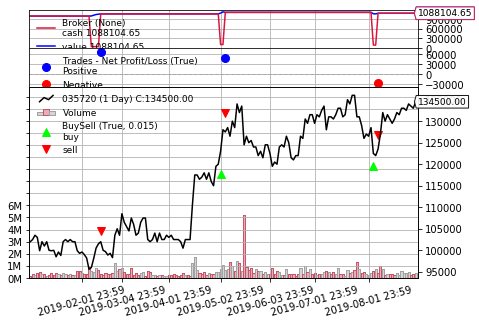

In [10]:
data = bt.feeds.YahooFinanceData(dataname='035720.KS',
                                     fromdate=datetime.datetime(2019, 1, 1),
                                     todate=datetime.datetime(2019, 8, 31))
if __name__ == '__main__':
    run(Performance,data)